# Keras LSTM

First, necessary libraries for this notebook are imported.

In [1]:
from pandas import read_csv, DataFrame, concat
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import concatenate
import numpy as np
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from timeit import default_timer as timer

Using TensorFlow backend.


## Metro Interstate Traffic Volume Data Set

**Source:** https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

**Data Set Information:** Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

**Attribute Information:**
- holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair.
- temp: Numeric Average temp in kelvin.
- rain_1h: Numeric Amount in mm of rain that occurred in the hour.
- snow_1h: Numeric Amount in mm of snow that occurred in the hour.
- clouds_all: Numeric Percentage of cloud cover.
- weather_main: Categorical Short textual description of the current weather.
- weather_description: Categorical Longer textual description of the current weather.
- date_time: DateTime Hour of the data collected in local CST time.
- traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume.

The data set is loaded, the variable "date_time" is assigned as an index, the variables are ordered by placing the output first for convenience and an example is shown.

In [2]:
dataset = read_csv('data/Metro_Interstate_Traffic_Volume.csv')
dataset.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
dataset = dataset.set_index('date_time')
dataset = dataset[['traffic_volume','holiday','temp','rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']]
dataset.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,,
2012-10-02 09:00:00,5545,None,288.28,0.0,0.0,40,Clouds,scattered clouds
2012-10-02 10:00:00,4516,None,289.36,0.0,0.0,75,Clouds,broken clouds
2012-10-02 11:00:00,4767,None,289.58,0.0,0.0,90,Clouds,overcast clouds
2012-10-02 12:00:00,5026,None,290.13,0.0,0.0,90,Clouds,overcast clouds
2012-10-02 13:00:00,4918,None,291.14,0.0,0.0,75,Clouds,broken clouds


In [4]:
# save to file
dataset.to_csv('data/Metro_Interstate_Traffic_Volume-final.csv')

The values are stored in an independent variable and some series are plotted.

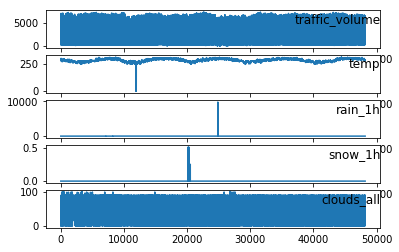

In [5]:
# load dataset
dataset = read_csv('data/Metro_Interstate_Traffic_Volume-final.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 2, 3, 4, 5]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Variables are normalized and the dataset is transformed into a supervised learning problem.Also, we keep only the input variables "t-1" and the output variable "var1(t)".

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# load dataset
dataset = read_csv('data/Metro_Interstate_Traffic_Volume-final.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values[:,6] = encoder.fit_transform(values[:,6])
values[:,7] = encoder.fit_transform(values[:,7])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.761676   0.636364   0.929726        0.0        0.0       0.40   
2   0.620330   0.636364   0.933209        0.0        0.0       0.75   
3   0.654808   0.636364   0.933918        0.0        0.0       0.90   
4   0.690385   0.636364   0.935692        0.0        0.0       0.90   
5   0.675550   0.636364   0.938949        0.0        0.0       0.75   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.1   0.648649  0.620330  
2        0.1   0.054054  0.654808  
3        0.1   0.513514  0.690385  
4        0.1   0.513514  0.675550  
5        0.1   0.054054  0.711676  


The LSTM model is defined with 50 neurons in the first hidden layer and 1 neuron in the output layer for prediction.

In [8]:
def create_model(shape_1, shape_2):
    model = Sequential()
    model.add(LSTM(50, input_shape=(shape_1, shape_2)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

A cross validation with a KFold of 10 is performed and the R^2, RMSE scores and average time are obtained.

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=False)
r2score_values = []
rmse_values = []
time_values = []

for train_index, test_index in kf.split(values):
    train, test = values.take(train_index, axis=0), values.take(test_index, axis=0)
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    start = timer()
    model = create_model(train_X.shape[1], train_X.shape[2])
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    end = timer()
    time_values.append(end-start)
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_values.append(rmse)
    # calculate r2_score
    r2score = r2_score(inv_y, inv_yhat)
    r2score_values.append(r2score)
    
    print(r2score, rmse)

print(f'Mean R^2 score => {np.mean(r2score_values)}\nMean RMSE => {np.mean(rmse_values)}\nMean time => {np.mean(time_values)}')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0.8191105098711878 846.8976103992737
0.7922725600194684 941.9042546883414
0.8182282704102115 837.7200457193322
0.7923537247788104 910.4347175937438
0.7489761440915175 1021.7010631784622
0.8190145362252594 800.5518409197496
0.8491772423047365 767.8856115984985
0.847926367065475 774.3946829621185
0.8527829559282116 750.4325002956629
0.8515622367985347 760.6886271662013
Mean R^2 score => 0.8191404547493413
Mean RMSE => 841.2610954521384
Mean time => 41.66871377389962


## Air Quality Data Set

**Source:** https://archive.ics.uci.edu/ml/datasets/Air+quality

**Data Set Information:** The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.

**Attribute Information:**
- Date: Date (DD/MM/YYYY).
- Time: Time (HH.MM.SS).
- CO(GT): True hourly averaged concentration CO in mg/m^3 (reference analyzer).
- PT08.S1(CO): PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted).
- NMHC(GT): True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer).
- C6H6(GT): True hourly averaged Benzene concentration in microg/m^3 (reference analyzer).
- PT08.S2(NMHC): PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted).
- NOx(GT): True hourly averaged NOx concentration in ppb (reference analyzer).
- PT08.S3(NOx): PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted).
- NO2(GT): True hourly averaged NO2 concentration in microg/m^3 (reference analyzer).
- PT08.S4(NO2): PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted).
- PT08.S5(O3): PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted).
- T: Temperature in °C.
- RH: Relative Humidity (%).
- AH: Absolute Humidity.

The data set is loaded, the timestamp is created using the variables "Date" and "Time", and output variable "CO(GT)" is renamed to "y" for prophet identification, and an example is shown.

In [10]:
dataset = pd.read_csv('data/AirQualityUCI.csv', sep=';')
dataset['ds'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], format='%d/%m/%Y %H.%M.%S')
dataset = dataset.drop(['Date', 'Time'], axis=1)
dataset = dataset.rename(columns={'CO(GT)': 'y'})
dataset = dataset.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
dataset.head()

,y,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,ds
0,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00


Null values are also checked and removed.

In [11]:
dataset.isnull().sum(axis = 0)

y                114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
ds               114
dtype: int64

In [12]:
dataset = dataset.dropna(how='all')
dataset.isnull().sum(axis = 0)

y                0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
ds               0
dtype: int64

Float values are checked and fixed, as they contain "," instead of ".

In [13]:
dataset.dtypes

y                        object
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                 object
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                        object
RH                       object
AH                       object
ds               datetime64[ns]
dtype: object

In [14]:
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].apply(lambda x: x.replace(',','.'))
dataset['T'] = dataset['T'].apply(lambda x: x.replace(',','.'))
dataset['RH'] = dataset['RH'].apply(lambda x: x.replace(',','.'))
dataset['AH'] = dataset['AH'].apply(lambda x: x.replace(',','.'))
dataset['y'] = dataset['y'].apply(lambda x: x.replace(',','.'))

dataset['PT08.S1(CO)'] = dataset['PT08.S1(CO)'].astype(float)
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].astype(float)
dataset['T'] = dataset['T'].astype(float)
dataset['RH'] = dataset['RH'].astype(float)
dataset['AH'] = dataset['AH'].astype(float)
dataset['y'] = dataset['y'].astype(float)

In [15]:
dataset.describe()

,y,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


As we have seen in the "describe", there are many values of "-200" in all columns, this may be due to missing values, so we will clean these values.

In [16]:
dataset = dataset[dataset["y"] != -200]
dataset = dataset.replace(-200, 0)
dataset.describe()

,y,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,7674.000000,7674.00000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000
mean,2.152750,1062.823169,25.93706,9.833855,906.466380,241.573365,791.360568,108.588090,1382.624967,998.639432,17.006255,46.950378,0.946904
std,1.453252,310.691637,99.99094,7.571930,323.064928,217.251773,301.959611,53.639799,450.968711,449.700751,9.389699,19.761648,0.439692
min,0.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.900000,0.000000,0.000000
25%,1.100000,927.000000,0.00000,4.100000,716.000000,90.000000,628.000000,73.000000,1157.000000,704.000000,10.300000,33.500000,0.650000
50%,1.800000,1062.000000,0.00000,8.100000,903.000000,177.000000,782.000000,107.000000,1425.000000,968.000000,16.300000,48.100000,0.940600
75%,2.900000,1235.000000,0.00000,14.000000,1116.750000,326.000000,949.000000,141.000000,1659.000000,1287.000000,23.500000,61.800000,1.235200
max,11.900000,2040.000000,1189.00000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


The variable "date_time" is assigned as an index.

In [17]:
dataset = dataset.set_index('ds')
dataset.head()

,y,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
ds,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [18]:
# save to file
dataset.to_csv('data/AirQualityUCI-final.csv')

The values are stored in an independent variable and some series are plotted.

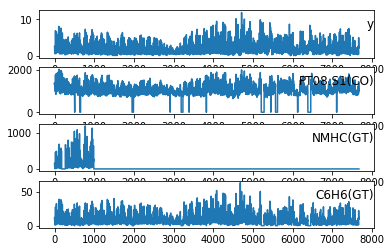

In [19]:
# load dataset
dataset = read_csv('data/AirQualityUCI-final.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0,1,2,3]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Variables are normalized and the dataset is transformed into a supervised learning problem. Also, we keep only the input variables "t-1" and the output variable "var1(t)".

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
# load dataset
dataset = read_csv('data/AirQualityUCI-final.csv', header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.columns
# drop columns we don't want to predict
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.211864   0.666667   0.126156   0.186813   0.472448   0.112238   
2   0.161017   0.633333   0.094197   0.147567   0.431346   0.069642   
3   0.177966   0.687255   0.074012   0.141287   0.424119   0.088573   
4   0.177966   0.674510   0.067283   0.144427   0.428184   0.116295   
5   0.127119   0.623529   0.042893   0.102041   0.377597   0.088573   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.393589   0.332353   0.609730    0.502576    0.333333    0.551297   
2   0.437570   0.270588   0.561802    0.385256    0.326882    0.537768   
3   0.424897   0.335294   0.560360    0.425684    0.296774    0.608794   
4   0.407007   0.358824   0.570811    0.476813    0.277419    0.676437   
5   0.449124   0.341176   0.536937    0.439952    0.281720    0.671928   

   var13(t-1)   var1(t)  
1    0.347519  0.161017  
2    0.332707  0.177966  
3    0.344034  0.177966  
4    0.360772  0.127119 

The LSTM model is defined with 50 neurons in the first hidden layer and 1 neuron in the output layer for prediction.

In [22]:
def create_model(shape_1, shape_2):
    model = Sequential()
    model.add(LSTM(50, input_shape=(shape_1, shape_2)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

A cross validation with a KFold of 10 is performed and the R^2, RMSE scores and average time are obtained.

In [23]:
kf = KFold(n_splits=10, random_state=42, shuffle=False)
r2score_values = []
rmse_values = []
time_values = []

for train_index, test_index in kf.split(values):
    train, test = values.take(train_index, axis=0), values.take(test_index, axis=0)
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    start = timer()
    model = create_model(train_X.shape[1], train_X.shape[2])
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    end = timer()
    time_values.append(end-start)
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_values.append(rmse)
    # calculate r2_score
    r2score = r2_score(inv_y, inv_yhat)
    r2score_values.append(r2score)
    
    print(r2score, rmse)

print(f'Mean R^2 score => {np.mean(r2score_values)}\nMean RMSE => {np.mean(rmse_values)}\nMean time => {np.mean(time_values)}')

0.6353323646140203 0.7996031492109241
0.6289897034779859 0.8096548664402609
0.6057444997318936 0.7052854407532182
0.6593708190448795 0.5816251887213153
0.6732397704601238 0.7691868819958575
0.7179704024807354 0.8930403099189173
0.7331113703600061 0.9641426102602582
0.6666831098275099 0.9078155346818059
0.6216609133914596 0.810596767866259
0.6916661359868297 0.7609614202041343
Mean R^2 score => 0.6633769089375444
Mean RMSE => 0.800191217005295
Mean time => 9.488671151400194


## example_wp_log_peyton_manning

**Source:** https://github.com/facebook/prophet/blob/master/examples/example_wp_log_peyton_manning.csv

**Data Set Information:** The dataset contains 2905 instances of the log daily page views for the Wikipedia page for Peyton Manning.

**Attribute Information:**
- ds: Date (YYYY-MM-DD).
- y: Number of views.

The data set is loaded and an example is shown.

In [24]:
dataset = pd.read_csv('data/example_wp_log_peyton_manning.csv')
dataset.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


The variable "ds" is assigned as an index.

In [25]:
dataset = dataset.set_index('ds')
dataset.head()

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572


The values are stored in an independent variable and the series are plotted.

In [26]:
# save to file
dataset.to_csv('data/example_wp_log_peyton_manning-final.csv')

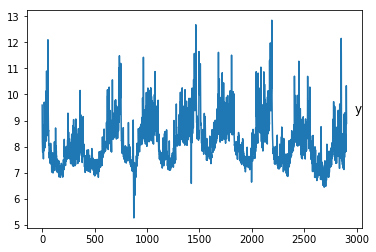

In [27]:
# load dataset
dataset = read_csv('data/example_wp_log_peyton_manning-final.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Variables are normalized and the dataset is transformed into a supervised learning problem. Also, we keep only the input variable "t-1" and the output variable "var1(t)".

In [28]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
# load dataset
dataset = read_csv('data/example_wp_log_peyton_manning-final.csv', header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# reframed.columns
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values

   var1(t-1)   var1(t)
1   0.570680  0.429440
2   0.429440  0.385148
3   0.385148  0.370485
4   0.370485  0.346896
5   0.346896  0.332401


The LSTM model is defined with 50 neurons in the first hidden layer and 1 neuron in the output layer for prediction.

In [30]:
def create_model(shape_1, shape_2):
    model = Sequential()
    model.add(LSTM(50, input_shape=(shape_1, shape_2)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

A cross validation with a KFold of 10 is performed and the R^2, RMSE scores and average time are obtained.

In [31]:
kf = KFold(n_splits=10, random_state=42, shuffle=False)
r2score_values = []
rmse_values = []
time_values = []

for train_index, test_index in kf.split(values):
    train, test = values.take(train_index, axis=0), values.take(test_index, axis=0)
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    start = timer()
    model = create_model(train_X.shape[1], train_X.shape[2])
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    end = timer()
    time_values.append(end-start)
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_values.append(rmse)
    # calculate r2_score
    r2score = r2_score(inv_y, inv_yhat)
    r2score_values.append(r2score)
    
    print(r2score, rmse)

print(f'Mean R^2 score => {np.mean(r2score_values)}\nMean RMSE => {np.mean(rmse_values)}\nMean time => {np.mean(time_values)}')

0.6375223148322235 0.4186773621487325
0.5071726616863326 0.32983003129714983
0.5788784280039065 0.5253225800082103
0.5784726416405703 0.5258010055662242
0.5668444474421703 0.5216459673998884
0.5696377245787705 0.5816941020865937
0.7042871777625046 0.40286546972958537
0.6338582349053425 0.6119414108209061
0.5270541949422725 0.5038601758134715
0.5216035444517709 0.511229652615454
Mean R^2 score => 0.5825331370245864
Mean RMSE => 0.4932867757486217
Mean time => 6.55130692440016
